## NLP & MultiClass Classification: Sentiment Analysis on Movie Reviews
https://www.kaggle.com/c/sentiment-analysis-on-movie-reviews

** Dataset Information: **

- 156060 Rotten Tomatoes' Movie Reviews

** Attribute Information:**

- PhraseId   
- SentenceId  
- Phrase        
- Sentiment

** Objective of this project **

- Classify the sentiment of sentences from the Rotten Tomatoes dataset

# Data

In [0]:
# Load libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import warnings
warnings.filterwarnings("ignore")

In [6]:
# Load Data
filepath = 'drive/app/reviews/'
df = pd.read_csv(filepath+'train.tsv', delimiter='\t')
pd.set_option('display.max_colwidth', -1)
df.head()

,PhraseId,SentenceId,Phrase,Sentiment
0,1,1,"A series of escapades demonstrating the adage that what is good for the goose is also good for the gander , some of which occasionally amuses but none of which amounts to much of a story .",1
1,2,1,A series of escapades demonstrating the adage that what is good for the goose,2
2,3,1,A series,2
3,4,1,A,2
4,5,1,series,2


In [7]:
df['Phrase'].tail()

156055    Hearst 's                
156056    forced avuncular chortles
156057    avuncular chortles       
156058    avuncular                
156059    chortles                 
Name: Phrase, dtype: object

In [0]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 156060 entries, 0 to 156059
Data columns (total 4 columns):
PhraseId      156060 non-null int64
SentenceId    156060 non-null int64
Phrase        156060 non-null object
Sentiment     156060 non-null int64
dtypes: int64(3), object(1)
memory usage: 4.8+ MB


In [0]:
df.describe()

,PhraseId,SentenceId,Sentiment
count,156060.000000,156060.000000,156060.000000
mean,78030.500000,4079.732744,2.063578
std,45050.785842,2502.764394,0.893832
min,1.000000,1.000000,0.000000
25%,39015.750000,1861.750000,2.000000
50%,78030.500000,4017.000000,2.000000
75%,117045.250000,6244.000000,3.000000
max,156060.000000,8544.000000,4.000000


# Exploratory Data Analysis

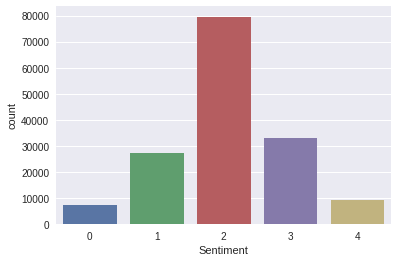

In [8]:
# inspect sentiment
sns.countplot(df['Sentiment'])

In [9]:
# text length
df['text_length'] = df['Phrase'].apply(len)
df[['Sentiment','text_length','Phrase']].head()

,Sentiment,text_length,Phrase
0,1,188,"A series of escapades demonstrating the adage that what is good for the goose is also good for the gander , some of which occasionally amuses but none of which amounts to much of a story ."
1,2,77,A series of escapades demonstrating the adage that what is good for the goose
2,2,8,A series
3,2,1,A
4,2,6,series


In [10]:
df['text_length'].describe()

count    156060.000000
mean     40.217224    
std      38.154130    
min      1.000000     
25%      14.000000    
50%      26.000000    
75%      53.000000    
max      283.000000   
Name: text_length, dtype: float64

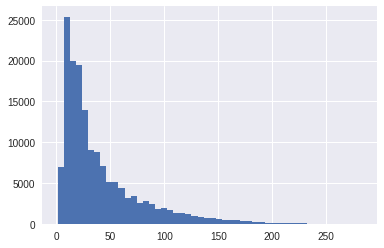

In [11]:
df['text_length'].hist(bins=50)

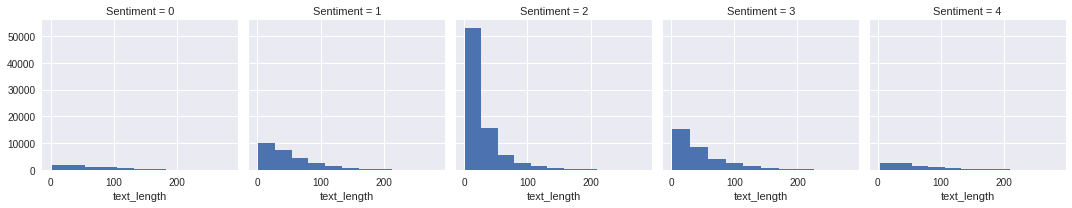

In [12]:
g = sns.FacetGrid(df,col='Sentiment')
g.map(plt.hist,'text_length')

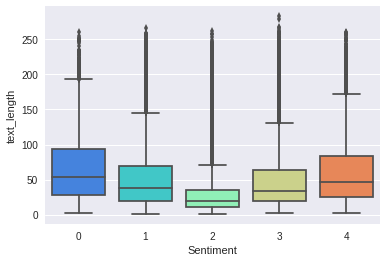

In [13]:
sns.boxplot(x='Sentiment',y='text_length',data=df,palette='rainbow')

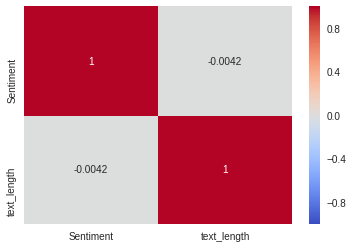

In [14]:
sns.heatmap(df[['Sentiment','text_length']].corr(), annot = True, cmap='coolwarm')

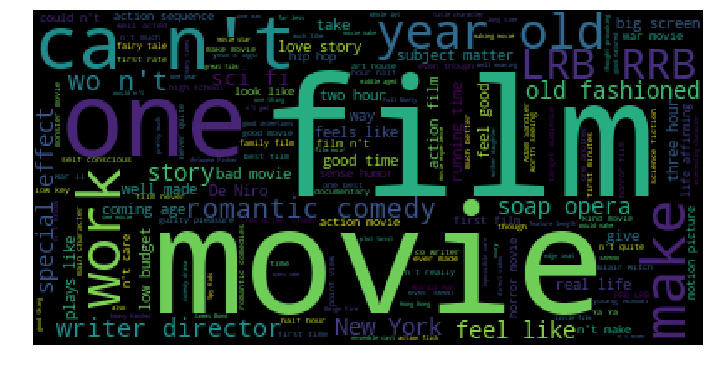

In [0]:
# word cloud
from nltk.corpus import stopwords
from wordcloud import WordCloud

text = df['Phrase'].to_string()
wordcloud = WordCloud(
        relative_scaling=0.5,
        stopwords=set(stopwords.words('english'))).generate(text)

plt.figure(figsize=(12,12))
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

# Data Preprocessing

#### Encode Categorical Variable

In [15]:
from keras.utils import to_categorical
X = df['Phrase']
y = to_categorical(df['Sentiment'])
num_classes = df['Sentiment'].nunique()
y

Using TensorFlow backend.


array([[0., 1., 0., 0., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0.],
       ...,
       [0., 0., 0., 1., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0.]])

#### Spilt Train Test sets

In [0]:
seed = 101 # fix random seed for reproducibility
np.random.seed(seed)

In [17]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=0.2,
                                                    stratify=y,
                                                    random_state=seed)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(124848,) (31212,) (124848, 5) (31212, 5)


#### Tokenize Text

In [0]:
from keras.preprocessing.text import Tokenizer
max_features = 15000
tokenizer = Tokenizer(num_words=max_features)
tokenizer.fit_on_texts(list(X_train))
X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)

In [19]:
len(X_train)
#X_train[:10]
#tokenizer.word_counts
#tokenizer.word_index

124848

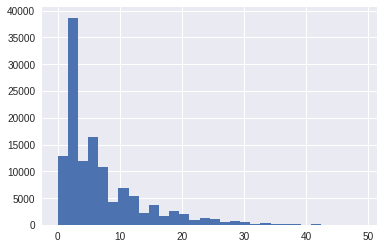

In [20]:
totalNumWords = [len(one_comment) for one_comment in X_train]
plt.hist(totalNumWords,bins = 30)
plt.show()

In [21]:
from keras.preprocessing import sequence
max_words = 30 #max(totalNumWords)
X_train = sequence.pad_sequences(X_train, maxlen=max_words)
X_test = sequence.pad_sequences(X_test, maxlen=max_words)
print(X_train.shape,X_test.shape)
#X_train[np.argmax(totalNumWords)]

(124848, 30) (31212, 30)


# 1. dense+dense

In [0]:
import keras.backend as K
from keras.models import Sequential
from keras.layers import Dense,Flatten,Embedding,Dropout,Conv1D,MaxPooling1D,LSTM,Bidirectional
from sklearn.metrics import accuracy_score,confusion_matrix,classification_report
from keras.callbacks import ModelCheckpoint,EarlyStopping

batch_size = 256
epochs = 50
filepath = 'weights_best_model.hdf5'

In [0]:
def get_model(max_features, embed_dim):
    np.random.seed(seed)
    K.clear_session()
    model = Sequential()
    model.add(Embedding(max_features, embed_dim, input_length=X_train.shape[1]))
    model.add(Flatten())
    model.add(Dense(60, activation='relu'))
    model.add(Dropout(0.2, seed=seed))
    model.add(Dense(30, activation='relu'))
    model.add(Dropout(0.2, seed=seed))
    model.add(Dense(num_classes, activation='softmax'))
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    print(model.summary())    
    return model

In [0]:
def model_train(model):
    # callbacks
    early_stop = EarlyStopping(monitor='val_acc', patience=5, verbose=0, mode='max') 
    checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')
    callbacks_list = [checkpoint, early_stop]
    # train the model
    model_history = model.fit(X_train, y_train, validation_data=(X_test, y_test), 
                          epochs=epochs, batch_size=batch_size,
                          verbose=0, callbacks=callbacks_list)
    # plot train history
    plot_model_history(model_history)

In [0]:
def plot_model_history(model_history):
    fig, axs = plt.subplots(1,2,figsize=(15,5))
    # summarize history for accuracy
    axs[0].plot(range(1,len(model_history.history['acc'])+1),model_history.history['acc'])
    axs[0].plot(range(1,len(model_history.history['val_acc'])+1),model_history.history['val_acc'])
    axs[0].set_title('Model Accuracy')
    axs[0].set_ylabel('Accuracy')
    axs[0].set_xlabel('Epoch')
    axs[0].set_xticks(np.arange(1,len(model_history.history['acc'])+1),len(model_history.history['acc'])/10)
    axs[0].legend(['train', 'val'], loc='best')
    # summarize history for loss
    axs[1].plot(range(1,len(model_history.history['loss'])+1),model_history.history['loss'])
    axs[1].plot(range(1,len(model_history.history['val_loss'])+1),model_history.history['val_loss'])
    axs[1].set_title('Model Loss')
    axs[1].set_ylabel('Loss')
    axs[1].set_xlabel('Epoch')
    axs[1].set_xticks(np.arange(1,len(model_history.history['loss'])+1),len(model_history.history['loss'])/10)
    axs[1].legend(['train', 'val'], loc='best')
    plt.show()

In [0]:
def model_evaluate(): 
    # predict class with test set
    model.load_weights(filepath)
    y_pred_test =  model.predict_classes(X_test, batch_size=batch_size, verbose=0)
    print('Accuracy:\t{:0.1f}%'.format(accuracy_score(np.argmax(y_test,axis=1),y_pred_test)*100))
    
    #classification report
    print('\n')
    print(classification_report(np.argmax(y_test,axis=1), y_pred_test))

    #confusion matrix
    confmat = confusion_matrix(np.argmax(y_test,axis=1), y_pred_test)

    fig, ax = plt.subplots(figsize=(4, 4))
    ax.matshow(confmat, cmap=plt.cm.Blues, alpha=0.3)
    for i in range(confmat.shape[0]):
        for j in range(confmat.shape[1]):
            ax.text(x=j, y=i, s=confmat[i, j], va='center', ha='center')
    plt.xlabel('Predicted label')
    plt.ylabel('True label')
    plt.tight_layout()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 30, 100)           1500000   
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 30, 32)            9632      
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 15, 32)            0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 15, 32)            3104      
_________________________________________________________________
max_pooling1d_2 (MaxPooling1 (None, 7, 32)             0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 224)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 30)                6750      
__________

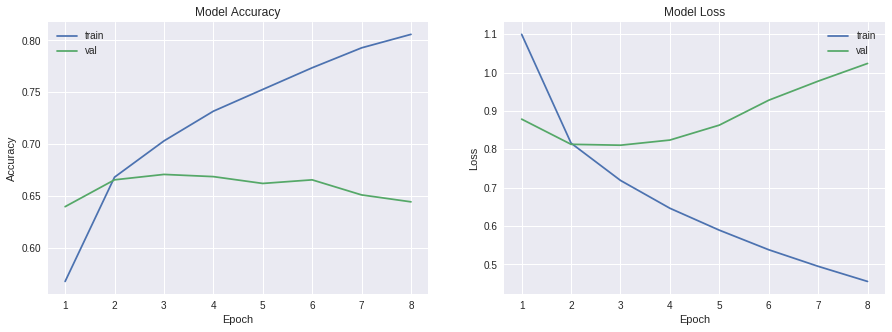

In [39]:
# train the model
max_features = 15000
embed_dim = 100
model = get_model(max_features, embed_dim)
model_train(model)

Accuracy:	67.1%


             precision    recall  f1-score   support

          0       0.53      0.37      0.44      1414
          1       0.55      0.56      0.56      5455
          2       0.76      0.80      0.78     15917
          3       0.59      0.57      0.58      6585
          4       0.58      0.44      0.50      1841

avg / total       0.66      0.67      0.67     31212



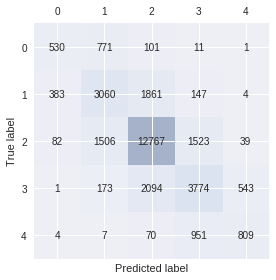

In [40]:
# evaluate model with test set
model_evaluate()

# 2. conv+dense

In [0]:
def get_model(max_features, embed_dim):
    np.random.seed(seed)
    K.clear_session()
    model = Sequential()
    model.add(Embedding(max_features, embed_dim, input_length=X_train.shape[1]))
    model.add(Conv1D(filters=32, kernel_size=3, padding='same', activation='relu'))
    model.add(MaxPooling1D(pool_size=2))
    model.add(Conv1D(filters=32, kernel_size=3, padding='same', activation='relu'))
    model.add(MaxPooling1D(pool_size=2))
    model.add(Flatten())
    model.add(Dense(30, activation='relu'))
    model.add(Dropout(0.2, seed=seed))
    model.add(Dense(num_classes, activation='softmax'))
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    print(model.summary())
    return model

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 30, 100)           1500000   
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 30, 32)            9632      
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 15, 32)            0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 15, 32)            3104      
_________________________________________________________________
max_pooling1d_2 (MaxPooling1 (None, 7, 32)             0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 224)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 30)                6750      
__________

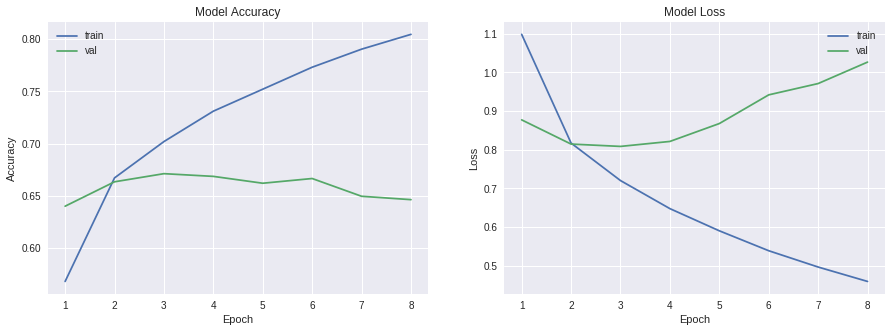

In [42]:
# train the model
max_features = 15000
embed_dim = 100
model = get_model(max_features, embed_dim)
model_train(model)

Accuracy:	67.1%


             precision    recall  f1-score   support

          0       0.50      0.38      0.43      1414
          1       0.54      0.59      0.56      5455
          2       0.76      0.80      0.78     15917
          3       0.60      0.57      0.58      6585
          4       0.58      0.42      0.49      1841

avg / total       0.67      0.67      0.67     31212



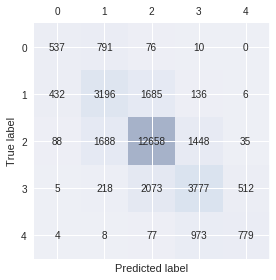

In [43]:
# evaluate model with test set
model_evaluate()

# 3. lstm

In [0]:
def get_model(max_features, embed_dim):
    np.random.seed(seed)
    K.clear_session()
    model = Sequential()
    model.add(Embedding(max_features, embed_dim, input_length=X_train.shape[1]))
    model.add(LSTM(100, dropout=0.2, recurrent_dropout=0.2))
    model.add(Dense(num_classes, activation='softmax'))
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    print(model.summary())
    return model

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 30, 100)           1500000   
_________________________________________________________________
lstm_1 (LSTM)                (None, 100)               80400     
_________________________________________________________________
dense_1 (Dense)              (None, 5)                 505       
Total params: 1,580,905
Trainable params: 1,580,905
Non-trainable params: 0
_________________________________________________________________
None

Epoch 00001: val_acc improved from -inf to 0.64664, saving model to weights_best_model.hdf5

Epoch 00002: val_acc improved from 0.64664 to 0.66378, saving model to weights_best_model.hdf5

Epoch 00003: val_acc improved from 0.66378 to 0.67163, saving model to weights_best_model.hdf5

Epoch 00004: val_acc did not improve

Epoch 00005: val_acc improved from 0.67163 to 0.67349, saving model

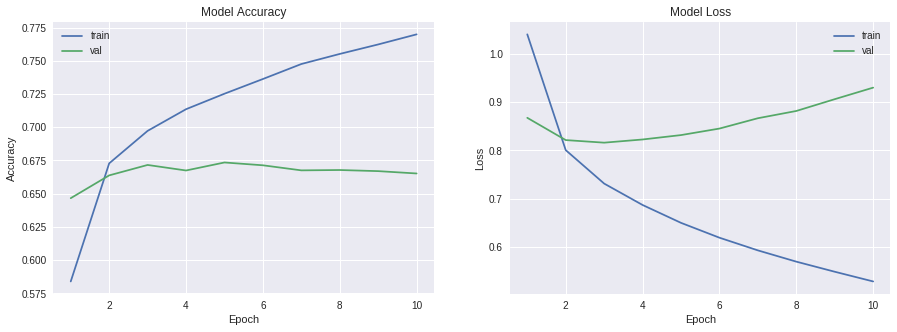

In [45]:
# train the model
max_features = 15000
embed_dim = 100
model = get_model(max_features, embed_dim)
model_train(model)

Accuracy:	67.3%


             precision    recall  f1-score   support

          0       0.53      0.38      0.44      1414
          1       0.56      0.54      0.55      5455
          2       0.74      0.82      0.78     15917
          3       0.60      0.56      0.58      6585
          4       0.63      0.39      0.48      1841

avg / total       0.67      0.67      0.67     31212



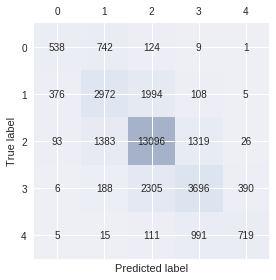

In [46]:
# evaluate model with test set
model_evaluate()

# 4. bidirectional lstm

In [0]:
def get_model(max_features, embed_dim):
    np.random.seed(seed)
    K.clear_session()
    model = Sequential()
    model.add(Embedding(max_features, embed_dim, input_length=X_train.shape[1]))
    model.add(Bidirectional(LSTM(100)))
    model.add(Dropout(0.5, seed=seed))
    model.add(Dense(num_classes, activation='softmax'))
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    print(model.summary())
    return model

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 30, 100)           1500000   
_________________________________________________________________
bidirectional_1 (Bidirection (None, 200)               160800    
_________________________________________________________________
dropout_1 (Dropout)          (None, 200)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 5)                 1005      
Total params: 1,661,805
Trainable params: 1,661,805
Non-trainable params: 0
_________________________________________________________________
None

Epoch 00001: val_acc improved from -inf to 0.64812, saving model to weights_best_model.hdf5

Epoch 00002: val_acc improved from 0.64812 to 0.66282, saving model to weights_best_model.hdf5

Epoch 00003: val_acc improved from 0.66282 to 0.66971, saving model t

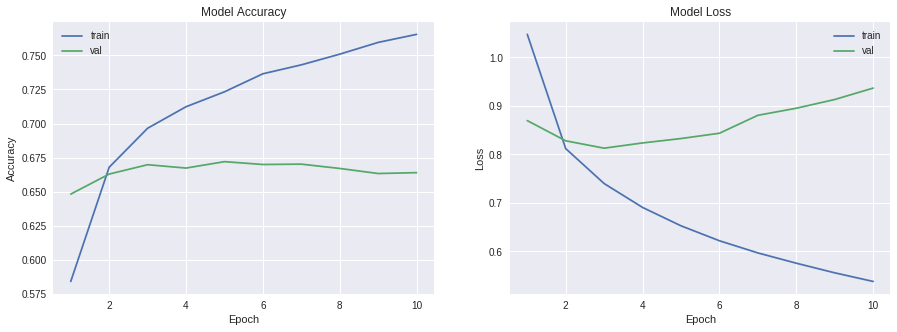

In [53]:
# train the model
max_features = 15000
embed_dim = 100
model = get_model(max_features, embed_dim)
model_train(model)

Accuracy:	67.2%


             precision    recall  f1-score   support

          0       0.60      0.29      0.39      1414
          1       0.54      0.63      0.58      5455
          2       0.75      0.80      0.78     15917
          3       0.60      0.57      0.58      6585
          4       0.65      0.35      0.46      1841

avg / total       0.67      0.67      0.66     31212



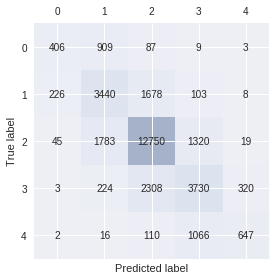

In [54]:
# evaluate model with test set
model_evaluate()

# 5. conv+lstm

In [0]:
def get_model(max_features, embed_dim):
    np.random.seed(seed)
    K.clear_session()
    model = Sequential()
    model.add(Embedding(max_features, embed_dim, input_length=X_train.shape[1]))
    model.add(Conv1D(filters=32, kernel_size=3, padding='same', activation='relu'))
    model.add(MaxPooling1D(pool_size=2))
    model.add(Conv1D(filters=32, kernel_size=3, padding='same', activation='relu'))
    model.add(MaxPooling1D(pool_size=2))    
    model.add(LSTM(100, dropout=0.2, recurrent_dropout=0.2))
    model.add(Dense(num_classes, activation='softmax'))
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    print(model.summary())
    return model

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 30, 100)           1500000   
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 30, 32)            9632      
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 15, 32)            0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 15, 32)            3104      
_________________________________________________________________
max_pooling1d_2 (MaxPooling1 (None, 7, 32)             0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 100)               53200     
_________________________________________________________________
dense_1 (Dense)              (None, 5)                 505       
Total para

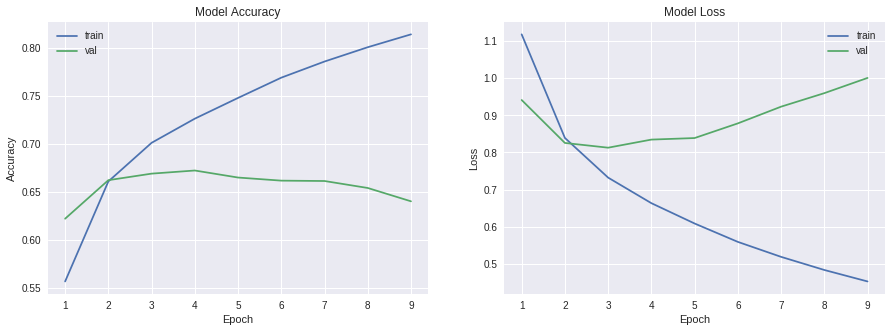

In [50]:
# train the model
max_features = 15000
embed_dim = 100
model = get_model(max_features, embed_dim)
model_train(model)

Accuracy:	67.2%


             precision    recall  f1-score   support

          0       0.60      0.27      0.37      1414
          1       0.56      0.55      0.56      5455
          2       0.74      0.82      0.78     15917
          3       0.58      0.61      0.59      6585
          4       0.67      0.27      0.39      1841

avg / total       0.67      0.67      0.66     31212



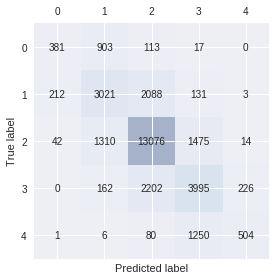

In [51]:
# evaluate model with test set
model_evaluate()

# 6. GloVe.6B.50d+lstm

In [0]:
def get_coefs(word, *arr):
    return word, np.asarray(arr, dtype='float32')
    
def get_embed_mat(EMBEDDING_FILE, max_features=20000):
    # word vectors
    embeddings_index = dict(get_coefs(*o.rstrip().rsplit(' ')) for o in open(EMBEDDING_FILE, encoding='utf8'))
    print('Found %s word vectors.' % len(embeddings_index))

    # embedding matrix
    word_index = tokenizer.word_index
    num_words = min(max_features, len(word_index) + 1)
    all_embs = np.stack(embeddings_index.values()) #for random init
    embedding_matrix = np.random.normal(all_embs.mean(), all_embs.std(), 
                                        (num_words, embed_dim))
    for word, i in word_index.items():
        if i >= max_features:
            continue
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector
    max_features = embedding_matrix.shape[0]
    
    return max_features, embedding_matrix

In [0]:
def get_model(max_features, embed_dim, embedding_matrix):
    np.random.seed(seed)
    K.clear_session()
    model = Sequential()
    model.add(Embedding(max_features, embed_dim, input_length=X_train.shape[1],
                       weights=[embedding_matrix]))#,trainable=False
    model.add(LSTM(100, dropout=0.2, recurrent_dropout=0.2))
    model.add(Dense(num_classes, activation='softmax'))
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    print(model.summary())
    return model

Found 400000 word vectors.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 30, 50)            764050    
_________________________________________________________________
lstm_1 (LSTM)                (None, 100)               60400     
_________________________________________________________________
dense_1 (Dense)              (None, 5)                 505       
Total params: 824,955
Trainable params: 824,955
Non-trainable params: 0
_________________________________________________________________
None

Epoch 00001: val_acc improved from -inf to 0.62396, saving model to weights_best_model.hdf5

Epoch 00002: val_acc improved from 0.62396 to 0.64914, saving model to weights_best_model.hdf5

Epoch 00003: val_acc improved from 0.64914 to 0.66209, saving model to weights_best_model.hdf5

Epoch 00004: val_acc improved from 0.66209 to 0.66910, saving model to weights_bes

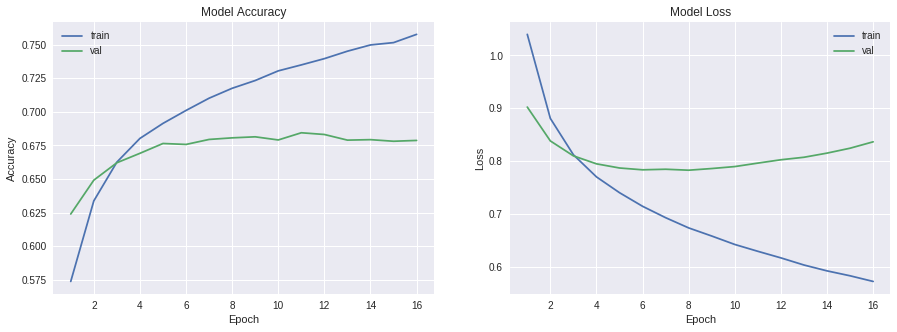

In [60]:
# embedding matrix
glove_filepath = 'drive/app/toxic/glove.6B/'
EMBEDDING_FILE = glove_filepath+'glove.6B.50d.txt'
embed_dim = 50 #word vector dim
max_features, embedding_matrix = get_embed_mat(EMBEDDING_FILE)

# train the model
model = get_model(max_features, embed_dim, embedding_matrix)
model_train(model)

Accuracy:	68.4%


             precision    recall  f1-score   support

          0       0.55      0.37      0.45      1414
          1       0.58      0.56      0.57      5455
          2       0.74      0.84      0.79     15917
          3       0.63      0.55      0.59      6585
          4       0.62      0.44      0.52      1841

avg / total       0.68      0.68      0.68     31212



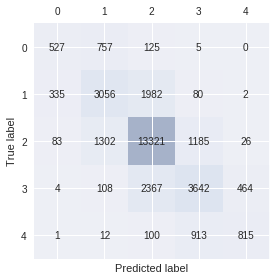

In [61]:
# evaluate model with test set
model_evaluate()

# 7. GloVe.6B.100d+lstm

Found 400000 word vectors.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 30, 100)           1528100   
_________________________________________________________________
lstm_1 (LSTM)                (None, 100)               80400     
_________________________________________________________________
dense_1 (Dense)              (None, 5)                 505       
Total params: 1,609,005
Trainable params: 1,609,005
Non-trainable params: 0
_________________________________________________________________
None

Epoch 00001: val_acc improved from -inf to 0.64116, saving model to weights_best_model.hdf5

Epoch 00002: val_acc improved from 0.64116 to 0.66420, saving model to weights_best_model.hdf5

Epoch 00003: val_acc improved from 0.66420 to 0.67394, saving model to weights_best_model.hdf5

Epoch 00004: val_acc improved from 0.67394 to 0.67852, saving model to weights

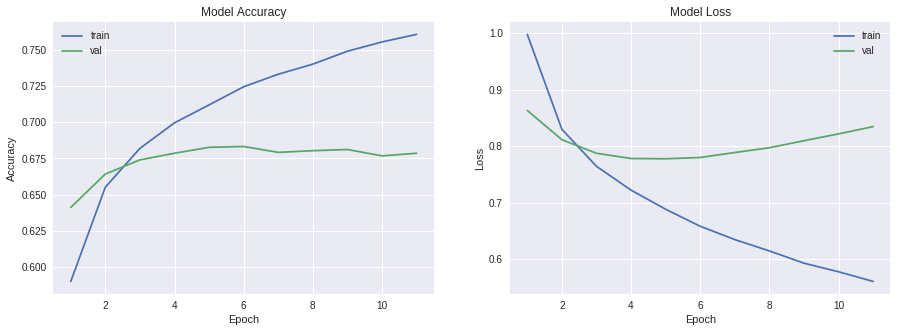

In [62]:
# embedding matrix
glove_filepath = 'drive/app/toxic/glove.6B/'
EMBEDDING_FILE = glove_filepath+'glove.6B.100d.txt'
embed_dim = 100 #word vector dim
max_features, embedding_matrix = get_embed_mat(EMBEDDING_FILE)

# train the model
model = get_model(max_features, embed_dim, embedding_matrix)
model_train(model)

Accuracy:	68.3%


             precision    recall  f1-score   support

          0       0.55      0.35      0.42      1414
          1       0.55      0.65      0.60      5455
          2       0.78      0.79      0.78     15917
          3       0.62      0.59      0.60      6585
          4       0.63      0.44      0.52      1841

avg / total       0.68      0.68      0.68     31212



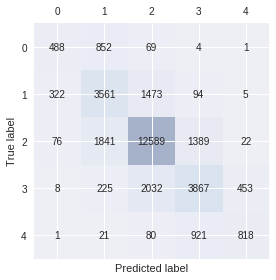

In [63]:
# evaluate model with test set
model_evaluate()